https://spectra.mathpix.com/article/2022.03.00973/high-dimension-data-analysis---a-tutorial-and-review-for-dimensionality-reduction-techniques

https://www.datacamp.com/tutorial/feature-selection-python

https://www.kaggle.com/datasets/paresh2047/uci-semcom?resource=download

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# Download the data

In [6]:
%%bash
rm secom.*
wget https://archive.ics.uci.edu/static/public/179/secom.zip
unzip secom.zip

Archive:  secom.zip
  inflating: secom.data              
  inflating: secom.names             
  inflating: secom_labels.data       


--2024-07-22 10:29:30--  https://archive.ics.uci.edu/static/public/179/secom.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘secom.zip’

     0K .......... .......... .......... .......... .......... 1.47M
    50K .......... .......... .......... .......... .......... 1.47M
   100K .......... .......... .......... .......... .......... 2.93M
   150K .......... .......... .......... .......... .......... 60.0M
   200K .......... .......... .......... .......... .......... 3.10M
   250K .......... .......... .......... .......... .......... 95.6M
   300K .......... .......... .......... .......... ..........  135M
   350K .......... .......... .......... .......... .......... 81.9M
   400K .......... .......... .......... .......... ..........  135M
   450K .......... .......... .......... ......

In [8]:
!ls -lh

total 7.1M
drwxr-xr-x 1 root root 4.0K Jul 18 13:22 sample_data
-rwx------ 1 root root 5.2M May 22  2023 secom.data
-rwx------ 1 root root  40K May 22  2023 secom_labels.data
-rwx------ 1 root root 4.2K May 22  2023 secom.names
-rw-r--r-- 1 root root 1.9M Jul 22 10:29 secom.zip


# Load in the data

We load in the the data as well as the labels as two seperate data frames, but we don't assign them, we rather concatenate them and then assign them to ```df```.


In [55]:
df = (pd.concat(
    [pd.read_csv('secom.data', sep=" ", header=None),

     pd.read_csv("secom_labels.data", sep=" ",
                header=None,
                parse_dates=[1], date_format='%d/%m/%Y %H:%M:%S',
                names=["PassFail", 'Time'])
    ],
    axis=1)
.replace({-1: 'pass', 1: 'fail'})
)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,582,583,584,585,586,587,588,589,PassFail,Time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,pass,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,pass,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,fail,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,pass,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,pass,2008-07-19 15:22:00


In [56]:
df.iloc[:, -5:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   587       1566 non-null   float64       
 1   588       1566 non-null   float64       
 2   589       1566 non-null   float64       
 3   PassFail  1567 non-null   object        
 4   Time      1567 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 61.3+ KB


# Look at missingness

Text(0.5, 1.0, 'Plot of missing values')

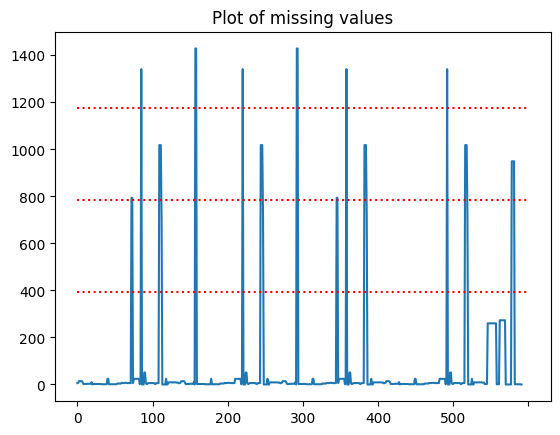

In [49]:
df.isna().sum().plot()
plt.hlines(xmin=0, xmax=600,
           y=[df.shape[0]*0.25, df.shape[0]*0.5, df.shape[0]*0.75],
           color='red', ls='dotted')
plt.title("Plot of missing values")

## Loose the *very* missing data

In [50]:
drop_mask = (df.isna().sum() <= df.shape[0] * 0.25).values
df_less_na = df[df.columns[drop_mask]]


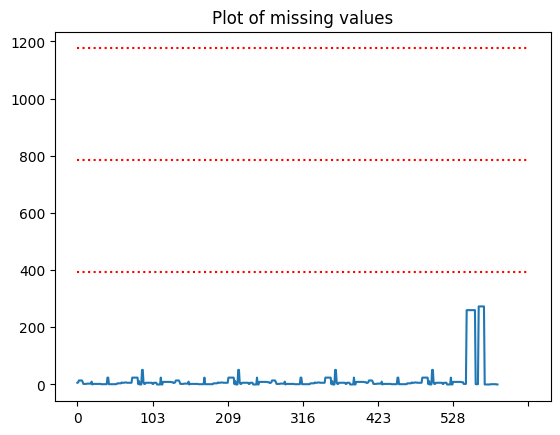

In [51]:
df_less_na.isna().sum().plot()
plt.hlines(xmin=0, xmax=600,
           y=[df.shape[0]*0.25, df.shape[0]*0.5, df.shape[0]*0.75],
           color='red', ls='dotted')
plt.title("Plot of missing values");

### Look at time and target

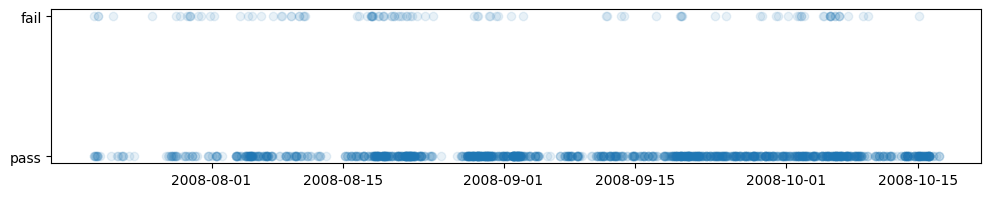

In [52]:
plt.figure(figsize=(12,2))
plt.scatter(df_less_na['Time'], df_less_na["PassFail"], alpha=0.1)

In [53]:
df_less_na['PassFail'].value_counts()

PassFail
pass    1463
fail     104
Name: count, dtype: int64

## Look at the variance in each column

In [ ]:
def minMax_scaler(x):
    x_norm = ( x-np.min(x) ) / ( np.max(x) - np.min(x) )
    return x_norm

In [ ]:
varDict = {}
very_low_var_cols = []
for col in df_less_na.drop(['Time', 'PassFail'], axis=1).columns:
    # normalize
    x_norm = minMax_scaler(df_less_na[col])
    var = np.var(x_norm)
    varDict[col] = var

    if np.isnan(var):
        very_low_var_cols.append(col)



In [ ]:
no_VarDf = df_less_na[very_low_var_cols]
some_VarDf = df_less_na.drop(very_low_var_cols, axis=1)

In [ ]:
no_VarDf.describe().T[['min']]['min']

5      100.0
13       0.0
42      70.0
49       1.0
52       0.0
       ...  
534      0.0
535      0.0
536      0.0
537      0.0
538      0.0
Name: min, Length: 116, dtype: float64

In [ ]:
no_VarDf.describe().T[['min']]['min']

5      100.0
13       0.0
42      70.0
49       1.0
52       0.0
       ...  
534      0.0
535      0.0
536      0.0
537      0.0
538      0.0
Name: min, Length: 116, dtype: float64

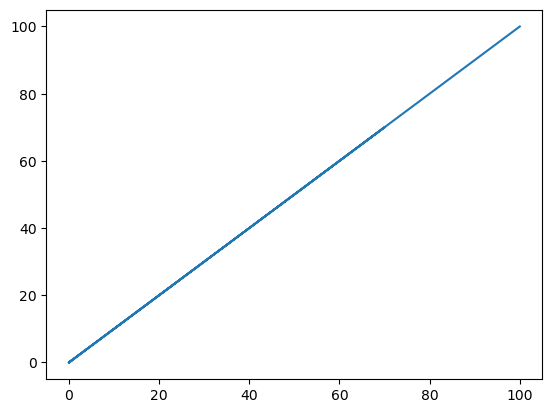

In [ ]:
plt.plot(no_VarDf.describe().T[['min']]['min'], no_VarDf.describe().T[['min']]['min'];

In [ ]:
some_VarDf.head()

,Time,0,1,2,3,4,6,7,8,9,...,582,583,584,585,586,587,588,589,PassFail,seconds
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,0
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2220
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,4920
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,10080
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,12420


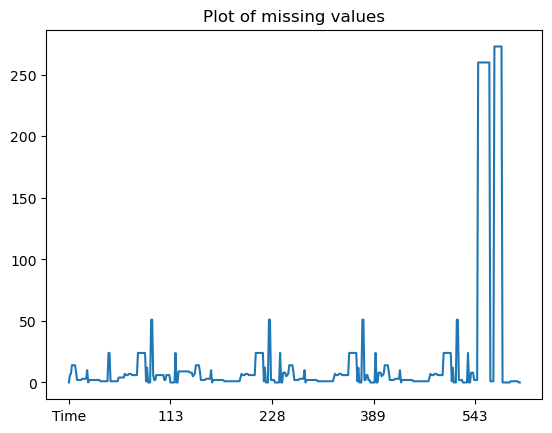

In [ ]:

some_VarDf.isna().sum().plot()
plt.title("Plot of missing values");

Unfortuanately we did not remove the more missing variables by dropping the low variance columns

## Imputation

In [ ]:
imputer = KNNImputer()
imputed = pd.DataFrame(imputer.fit_transform(some_VarDf
                                             .drop(['Time', 'seconds', 'PassFail'], axis=1)),
                       columns=some_VarDf.drop(['Time', 'seconds', 'PassFail'], axis=1).columns)
imputed['seconds'] = some_VarDf['seconds']
imputed['PassFail'] = some_VarDf['PassFail']


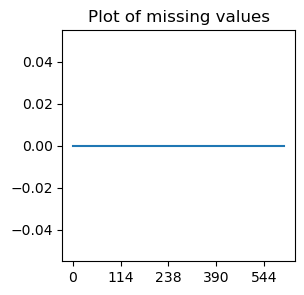

In [ ]:
plt.figure(figsize=(3,3))
imputed.isna().sum().plot()
plt.title("Plot of missing values");

(350.0, 500.0)

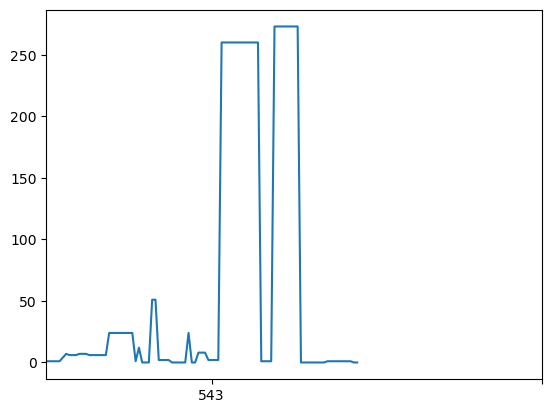

In [ ]:

some_VarDf.isna().sum().plot()
plt.xlim(350, 500)



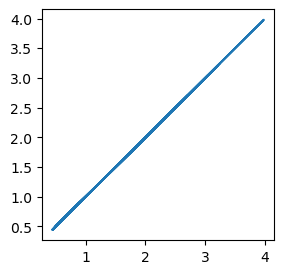

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(some_VarDf['546'], imputed['546']);

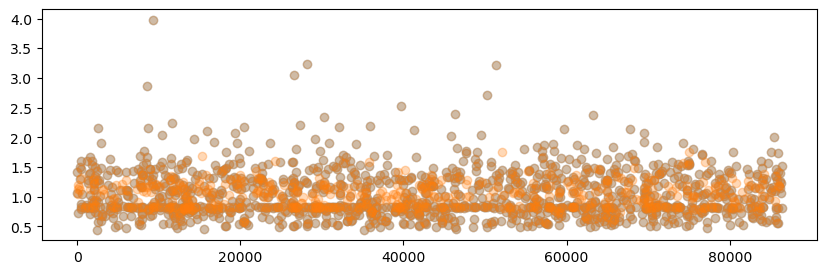

In [ ]:
plt.figure(figsize=(10, 3))
plt.scatter(some_VarDf['seconds'], some_VarDf['546'], alpha=0.3)
plt.scatter(imputed['seconds'], imputed['546'], alpha=0.3);

## PCA

We need to standardize the data

In [ ]:
scaler = StandardScaler()
imputed_scaled = scaler.fit_transform(imputed.drop(['PassFail', 'seconds'], axis=1))
pca = PCA()
pcaComps = pca.fit_transform(imputed_scaled)

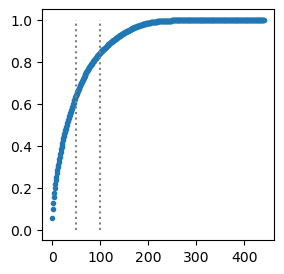

In [ ]:
plt.figure(figsize=(3,3))
#plt.plot(pca.explained_variance_ratio_, '.')
plt.plot(np.cumsum(pca.explained_variance_ratio_), '.')
plt.vlines(x=[50, 100], ymin=0, ymax=1, ls='dotted', color='gray');

In [ ]:
pcaDf = pd.DataFrame(pcaComps[:,0:4])
pcaDf['PassFail'] = imputed['PassFail']

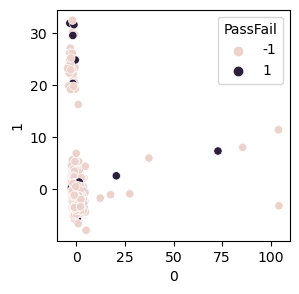

In [ ]:
plt.figure(figsize=(3,3))
sns.scatterplot(data=pcaDf, x=0, y=1, hue='PassFail');

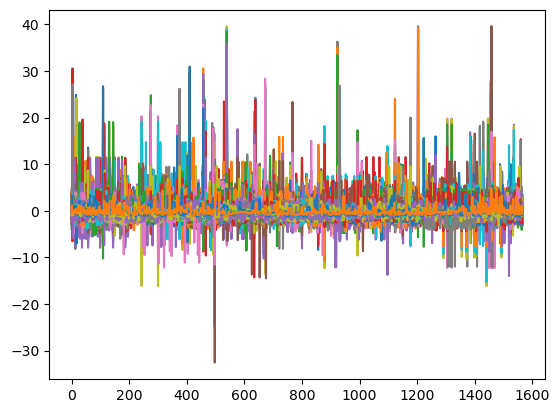

In [ ]:
plt.plot(imputed_scaled);

## Can we use the 'normal' correlation functions?

In [ ]:
imputed_scaled = pd.DataFrame(imputed_scaled,
                              columns=imputed.drop(
                                  ['seconds', 'PassFail'],
                                  axis=1).columns)
imputed_scaled

,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
0,0.226301,0.849728,-0.438109,0.032395,-0.050122,-0.560485,0.255040,0.509872,1.128455,-0.381082,...,-0.229797,-0.135520,0.118476,-0.204765,-0.093106,-0.196991,-0.164944,-0.433115,-0.315062,-0.363124
1,1.108313,-0.382754,1.014200,0.151616,-0.059586,0.200140,0.305366,0.457047,0.022693,-1.607666,...,-0.263493,-0.460054,0.529965,0.406796,0.444803,0.385174,-0.960061,0.412105,0.250318,1.156872
2,-1.110931,0.799112,-0.483091,0.683467,-0.047447,-0.902284,0.244975,-0.260840,0.327275,0.124615,...,-0.205046,-0.590505,-1.262951,0.022386,0.014476,0.029952,2.991230,3.627123,3.321515,-0.178909
3,-0.347789,-0.198742,-0.053674,-1.105336,-0.050831,0.504616,0.003412,0.343268,-0.765245,-0.370322,...,-0.224950,-0.645708,-0.322405,-0.292131,-0.362061,-0.283293,-0.101789,-0.178640,-0.308082,-0.275002
4,0.244118,0.087624,1.114374,-0.159612,-0.047034,-0.112890,0.184584,0.545089,-0.149461,-0.789943,...,-0.230791,-0.454486,-5.906897,26.867038,27.071310,26.913163,-0.101789,-0.178640,-0.308082,-0.275002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,-1.562478,-0.392479,-0.710275,3.831956,-0.047909,-3.031569,0.315431,-1.631597,-0.242160,-0.628550,...,-0.240947,-0.393931,-0.381189,-0.059155,0.014476,-0.056071,-1.186774,-0.303606,-0.203382,1.103241
1563,0.517086,0.332973,-0.069548,-0.617716,-0.058750,-0.422897,-0.117370,-0.400354,-0.348101,-1.015893,...,-0.268684,0.095786,-0.763286,-0.129048,-0.066211,-0.124056,-1.186774,-0.303606,-0.203382,1.103241
1564,-0.482573,-1.446933,0.193545,-0.649857,-0.059689,-0.271206,-0.087174,0.154180,-0.397099,-0.538171,...,-0.256565,0.086877,-0.410581,-0.000911,0.068267,-0.002348,-0.142273,-0.894351,-0.971181,-0.598121
1565,-1.623545,0.450910,-0.802131,-0.483664,-0.046335,-0.370007,-0.036849,-0.008902,-0.420936,0.329046,...,-0.227906,0.205751,0.089084,0.144699,-0.012420,0.139494,0.384026,0.911966,0.773817,-0.065585


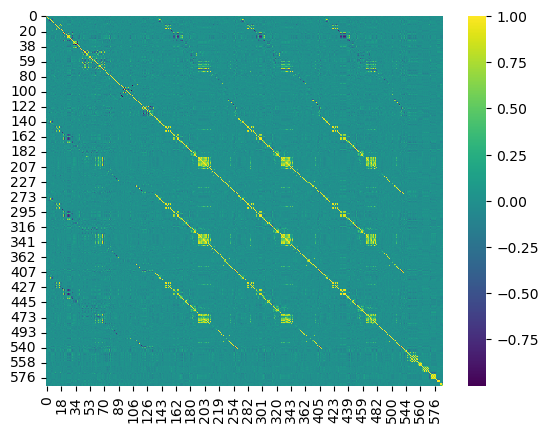

In [ ]:
corrMat = imputed_scaled.corr()
sns.heatmap(corrMat, cmap='viridis');

In [ ]:
discard = (abs(corrMat)
           .stack()
           .reset_index()
           .rename({'level_0': 'A',
                    'level_1': 'B',
                    0: 'corr'},
                   axis=1)

            .query("A != B")
            .query("corr > 0.8")
            .drop(['B', 'corr'], axis=1)
            .drop_duplicates()
            ['A']
            .values
          )
discard

array(['4', '16', '19', '25', '26', '27', '29', '30', '34', '36', '43',
       '45', '46', '50', '53', '54', '60', '64', '65', '66', '67', '70',
       '74', '92', '93', '94', '96', '98', '99', '101', '104', '105',
       '106', '114', '117', '119', '121', '122', '123', '124', '127',
       '130', '135', '136', '137', '138', '139', '140', '142', '143',
       '144', '145', '146', '147', '148', '150', '151', '152', '153',
       '154', '155', '156', '159', '160', '161', '162', '163', '164',
       '165', '166', '167', '168', '169', '170', '171', '172', '173',
       '174', '175', '176', '177', '180', '181', '182', '183', '184',
       '185', '187', '188', '195', '196', '197', '198', '199', '201',
       '202', '203', '204', '205', '206', '207', '208', '209', '210',
       '211', '212', '213', '214', '215', '216', '217', '218', '219',
       '221', '222', '223', '224', '225', '227', '228', '238', '239',
       '248', '249', '250', '251', '252', '253', '254', '255', '267',
       '268', '

In [ ]:
imputed_scaled = imputed_scaled.drop(discard, axis=1)

<Axes: >

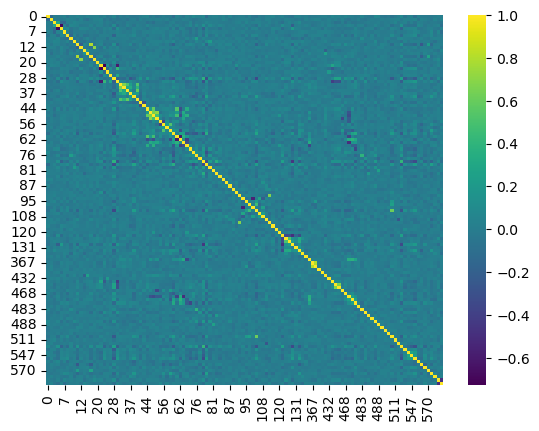

In [ ]:
sns.heatmap(imputed_scaled.corr(), cmap='viridis')

In [ ]:
imputed_scaled

,0,1,2,3,6,7,8,9,10,11,...,547,548,558,562,563,570,571,582,586,589
0,0.226301,0.849728,-0.438109,0.032395,-0.560485,0.255040,0.509872,1.128455,-0.381082,-1.514829,...,-1.751245,-0.095542,0.470196,-0.804524,-0.169237,0.190142,0.034410,0.118476,-0.164944,-0.363124
1,1.108313,-0.382754,1.014200,0.151616,0.200140,0.305366,0.457047,0.022693,-1.607666,-0.132491,...,1.030030,-0.435364,-0.376977,-0.676069,0.667239,0.256816,1.205944,0.529965,-0.960061,1.156872
2,-1.110931,0.799112,-0.483091,0.683467,-0.902284,0.244975,-0.260840,0.327275,0.124615,-0.228933,...,1.521611,-0.431086,6.050798,0.604831,1.951910,0.257279,-0.263745,-1.262951,2.991230,-0.178909
3,-0.347789,-0.198742,-0.053674,-1.105336,0.504616,0.003412,0.343268,-0.765245,-0.370322,-0.116417,...,-6.534164,-1.107064,1.984368,0.770598,-0.289063,0.002548,-0.278290,-0.322405,-0.101789,-0.275002
4,0.244118,0.087624,1.114374,-0.159612,-0.112890,0.184584,0.545089,-0.149461,-0.789943,-0.598628,...,-0.837890,0.944706,-0.205156,-0.597116,0.330338,0.085279,-0.270290,-5.906897,-0.101789,-0.275002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,-1.562478,-0.392479,-0.710275,3.831956,-3.031569,0.315431,-1.631597,-0.242160,-0.628550,-0.518260,...,-0.446813,0.336571,1.219526,0.207220,-1.035758,0.332578,-0.314650,-0.381189,-1.186774,1.103241
1563,0.517086,0.332973,-0.069548,-0.617716,-0.422897,-0.117370,-0.400354,-0.348101,-1.015893,-0.204822,...,-0.648659,-0.858920,-0.332828,0.571792,-0.517517,0.423157,0.289297,-0.763286,-1.186774,1.103241
1564,-0.482573,-1.446933,0.193545,-0.649857,-0.271206,-0.087174,0.154180,-0.397099,-0.538171,-0.767402,...,-2.703708,-0.583273,-0.276748,-0.866843,1.220327,-0.008730,0.878700,-0.410581,-0.142273,-0.598121
1565,-1.623545,0.450910,-0.802131,-0.483664,-0.370007,-0.036849,-0.008902,-0.420936,0.329046,0.405978,...,-0.648659,-0.858920,0.188601,0.207220,-1.035758,0.221215,-0.698253,0.089084,0.384026,-0.065585
